In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Asura\.cache\kagglehub\datasets\ealaxi\paysim1\versions\2


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import os

# Assuming the CSV file is named 'PS_20174392719_1491204439457_log.csv'
csv_file = os.path.join(path, 'PS_20174392719_1491204439457_log.csv')

# Read the CSV file
data = pd.read_csv(csv_file)
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.shape

(6362620, 11)

In [5]:
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
data['isFraud'].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

# Imbalanced dataset


In [8]:
data[data['isFraud']==1].type.value_counts()

type
CASH_OUT    4116
TRANSFER    4097
Name: count, dtype: int64

### since only these 2 types of transaction can result in fraud, we only have to check for these types of transactions

In [9]:
data = data.loc[(data['type'].isin(['TRANSFER', 'CASH_OUT']))].reset_index(drop=True)

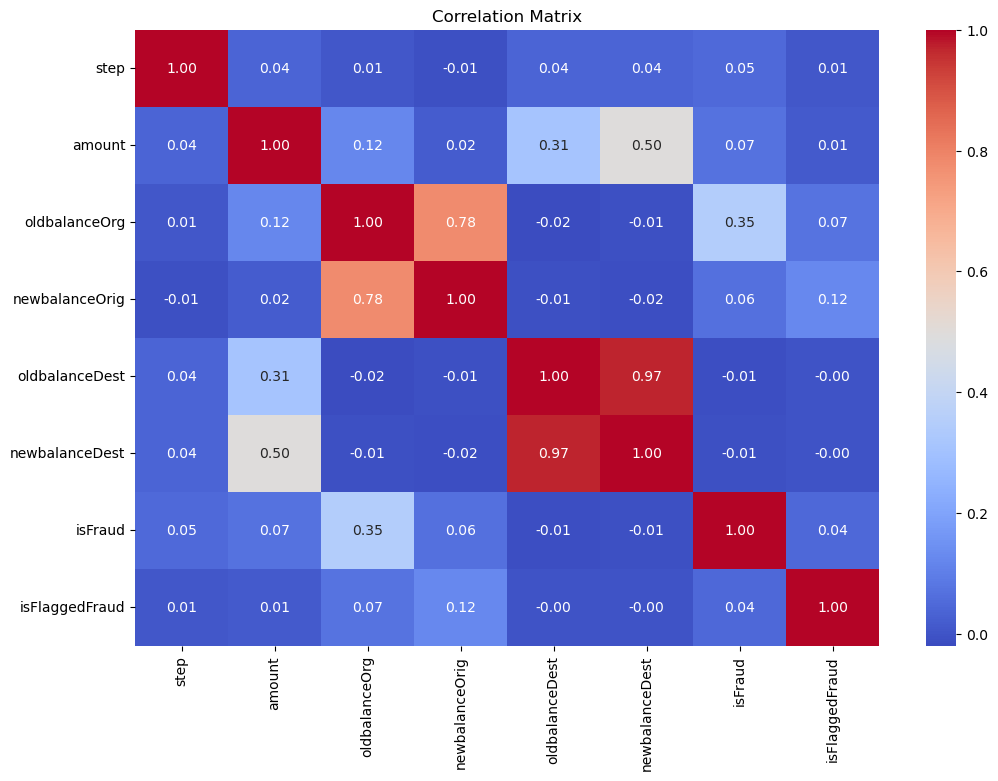

In [10]:
# Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [11]:
data = pd.get_dummies(data, columns=['type'], drop_first=True) # One hot encoding
data['balancedifferenceOrig'] = data['newbalanceOrig'] - data['oldbalanceOrg']  # Create new feature
data['balancedifferenceDest'] = data['oldbalanceDest'] - data['newbalanceDest']  # Create new feature
data['amountBalanceRatio'] = data['amount'] / (data['oldbalanceOrg'] + 1e-9)  # Create new feature
data.drop(['nameOrig', 'nameDest', 'isFlaggedFraud','step'], axis=1, inplace=True) # Drop unnecessary columns
data

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_TRANSFER,balancedifferenceOrig,balancedifferenceDest,amountBalanceRatio
0,181.00,181.00,0.0,0.00,0.00,1,True,-181.00,0.00,1.000000
1,181.00,181.00,0.0,21182.00,0.00,1,False,-181.00,21182.00,1.000000
2,229133.94,15325.00,0.0,5083.00,51513.44,0,False,-15325.00,-46430.44,14.951644
3,215310.30,705.00,0.0,22425.00,0.00,0,True,-705.00,22425.00,305.404681
4,311685.89,10835.00,0.0,6267.00,2719172.89,0,True,-10835.00,-2712905.89,28.766580
...,...,...,...,...,...,...,...,...,...,...
2770404,339682.13,339682.13,0.0,0.00,339682.13,1,False,-339682.13,-339682.13,1.000000
2770405,6311409.28,6311409.28,0.0,0.00,0.00,1,True,-6311409.28,0.00,1.000000
2770406,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,False,-6311409.28,-6311409.27,1.000000
2770407,850002.52,850002.52,0.0,0.00,0.00,1,True,-850002.52,0.00,1.000000


In [12]:
df_Majority = data[data['isFraud'] == 0]
df_Minority = data[data['isFraud'] == 1]

df_majority_downsampled = df_Majority.sample(n=len(df_Minority), random_state=28)
data2 = pd.concat([df_majority_downsampled, df_Minority])

In [13]:
from imblearn.over_sampling import SMOTE

X = data2.drop('isFraud', axis=1)
y = data2['isFraud']

# smote = SMOTE(sampling_strategy='not majority', random_state=28)
# X_resampled, y_resampled = smote.fit_resample(X, y)


In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=28, shuffle=True)

In [15]:
data.isFraud.value_counts()

isFraud
0    2762196
1       8213
Name: count, dtype: int64

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11498, 9), (4928, 9), (11498,), (4928,))

# NN model


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# Define the model
model = Sequential()

# Input layer
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Hidden layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

# Compile the model
adam = Adam(learning_rate=0.001)
sgd = SGD(learning_rate=0.001, momentum=0.9)
rmsprop = RMSprop(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,385 (64.00 KB)

 Non-trainable params: 576 (2.25 KB)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model2.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/25
142/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7875 - loss: 0.4470

144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7886 - loss: 0.4449 - val_accuracy: 0.6557 - val_loss: 0.5354 - learning_rate: 0.0010
Epoch 2/25
112/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8968 - loss: 0.2441

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8993 - loss: 0.2392 - val_accuracy: 0.8726 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 3/25
120/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9223 - loss: 0.1910

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9222 - loss: 0.1907 - val_accuracy: 0.9109 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 4/25
113/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9254 - loss: 0.1797

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9266 - loss: 0.1771 - val_accuracy: 0.9243 - val_loss: 0.1522 - learning_rate: 0.0010
Epoch 5/25
104/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9348 - loss: 0.1635

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9348 - loss: 0.1632 - val_accuracy: 0.9383 - val_loss: 0.1239 - learning_rate: 0.0010
Epoch 6/25
115/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9347 - loss: 0.1601

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9349 - loss: 0.1598 - val_accuracy: 0.9530 - val_loss: 0.1022 - learning_rate: 0.0010
Epoch 7/25
141/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9459 - loss: 0.1390

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9459 - loss: 0.1389 - val_accuracy: 0.9743 - val_loss: 0.0901 - learning_rate: 0.0010
Epoch 8/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9501 - loss: 0.1318 - val_accuracy: 0.9387 - val_loss: 0.1453 - learning_rate: 0.0010
Epoch 9/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9398 - loss: 0.1487 - val_accuracy: 0.9013 - val_loss: 0.1703 - learning_rate: 0.0010
Epoch 10/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9467 - loss: 0.1363 - val_accuracy: 0.9196 - val_loss: 0.2222 - learning_rate: 0.0010
Epoch 11/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9597 - loss: 0.1017 - val_accuracy: 0.9465 - val_loss: 0.1039 - learning_rate: 1.0000e-04
Epoch 12/25
106/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9654 - loss: 0.0962

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9653 - loss: 0.0967 - val_accuracy: 0.9804 - val_loss: 0.0690 - learning_rate: 1.0000e-04
Epoch 13/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9680 - loss: 0.0922 - val_accuracy: 0.9570 - val_loss: 0.0905 - learning_rate: 1.0000e-04
Epoch 14/25
139/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9661 - loss: 0.0936

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9661 - loss: 0.0937 - val_accuracy: 0.9787 - val_loss: 0.0670 - learning_rate: 1.0000e-04
Epoch 15/25
 87/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9639 - loss: 0.0976

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9646 - loss: 0.0966 - val_accuracy: 0.9843 - val_loss: 0.0642 - learning_rate: 1.0000e-04
Epoch 16/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9629 - loss: 0.0940 - val_accuracy: 0.9196 - val_loss: 0.1526 - learning_rate: 1.0000e-04
Epoch 17/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9663 - loss: 0.0895 - val_accuracy: 0.9513 - val_loss: 0.0978 - learning_rate: 1.0000e-04
Epoch 18/25
105/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9629 - loss: 0.0932

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9634 - loss: 0.0936 - val_accuracy: 0.9822 - val_loss: 0.0624 - learning_rate: 1.0000e-04
Epoch 19/25
101/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9710 - loss: 0.0853

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9711 - loss: 0.0848 - val_accuracy: 0.9843 - val_loss: 0.0568 - learning_rate: 1.0000e-04
Epoch 20/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9695 - loss: 0.0871 - val_accuracy: 0.9800 - val_loss: 0.0597 - learning_rate: 1.0000e-04
Epoch 21/25
103/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9717 - loss: 0.0823

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9710 - loss: 0.0828 - val_accuracy: 0.9839 - val_loss: 0.0537 - learning_rate: 1.0000e-04
Epoch 22/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9727 - loss: 0.0790 - val_accuracy: 0.9791 - val_loss: 0.0610 - learning_rate: 1.0000e-04
Epoch 23/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9716 - loss: 0.0807 - val_accuracy: 0.9639 - val_loss: 0.0791 - learning_rate: 1.0000e-04
Epoch 24/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9718 - loss: 0.0801 - val_accuracy: 0.9800 - val_loss: 0.0623 - learning_rate: 1.0000e-04
Epoch 25/25
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9728 - loss: 0.0867 - val_accuracy: 0.9787 - val_loss: 0.0652 - learning_rate: 1.0000e-05


In [22]:
# Predict on the test set
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.2).astype(int)

# Evaluate performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test, y_pred_proba))



154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      2467
           1       0.96      1.00      0.98      2461

    accuracy                           0.98      4928
   macro avg       0.98      0.98      0.98      4928
weighted avg       0.98      0.98      0.98      4928

Confusion Matrix:
 [[2365  102]
 [  11 2450]]
ROC-AUC Score: 0.9981804516900618
